In [290]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from dateutil import relativedelta
from dateutil.relativedelta import relativedelta

from pandasql import sqldf
pysqldf = lambda q: sqldf(q, globals())

from sklearn.linear_model import LinearRegression, Ridge, Lasso, BayesianRidge, Perceptron, PassiveAggressiveRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor

In [232]:
data = pd.read_excel('./BIMA_Commercial_Analyst_Assessment/sample_data.xlsx')

## EDA

In [233]:
[x.strftime('%Y/%m/%d') for x in data.confirmed_month]
# data.confirmed_month = data.confirmed_month.apply(lambda x:x.strftime('%Y/%m'))
# data.report_date = data.report_date.apply(lambda x:x.strftime('%Y/%m'))
data.individual_policy_price = data.individual_policy_price.apply(lambda x: int(x))
data.head(60)

,confirmed_month,report_date,individual_policy_price,total_customers_end_month,payments,total_deducted_customers_end_month
0,2013-01-01,2018-01-01,30,199,2703.0000,94
1,2013-01-01,2018-02-01,30,198,2480.0000,91
2,2013-01-01,2018-03-01,30,197,2789.0000,150
3,2013-01-01,2018-04-01,30,195,2486.0000,91
4,2013-01-01,2018-05-01,30,201,2518.0000,89
5,2013-01-01,2018-06-01,30,200,2428.0000,89
6,2013-01-01,2018-07-01,30,200,2493.0000,86
7,2013-01-01,2018-08-01,30,199,2531.0000,90
8,2013-01-01,2018-09-01,30,194,2520.0000,91
9,2013-01-01,2018-10-01,30,189,2403.0000,85


In [234]:
# Noticed this data isn't aggregated at month, report_date, policy price level
# need to fix that 

q = """
SELECT 
confirmed_month, 
report_date,
individual_policy_price,
SUM(total_customers_end_month) as total_customers_end_month,
SUM(payments) as payments,
SUM(total_deducted_customers_end_month) as total_deducted_customers_end_month
FROM data
GROUP BY 1,2,3
"""

data_c = pysqldf(q)

print('size of raw data:',len(data))
print('size after initial cleaning:',len(data_c))

size of raw data: 8538
size after initial cleaning: 7265


In [235]:
# Figure out how many people on each price plan

q = """
SELECT 
individual_policy_price, 
MAX(total_customers_end_month) as max_cust
FROM data_c
GROUP BY 1
"""

test = pysqldf(q)

print(test)

#Groups with high enough volume
sizable_policy = [30, 40, 60, 75, 80, 99, 100, 129, 150, 195, 300, 360]

data2 = data_c[data_c.individual_policy_price.isin(sizable_policy)]
print('')
print('length of data:', len(data_c))
print('length of data after filtered:', len(data2))

# some policies end at different dates, and it varies by start_month

    individual_policy_price  max_cust
0                        30     48256
1                        40     31363
2                        60     35015
3                        75     25566
4                        80     27189
5                        85         1
6                        99     48754
7                       100     17760
8                       129     35172
9                       150     16853
10                      170         3
11                      194         2
12                      195     11522
13                      213        10
14                      250         1
15                      274         4
16                      278         1
17                      300     13997
18                      324         1
19                      344         4
20                      360     12083
21                      409         2
22                      425         1
23                      429         2
24                      560         8
25          

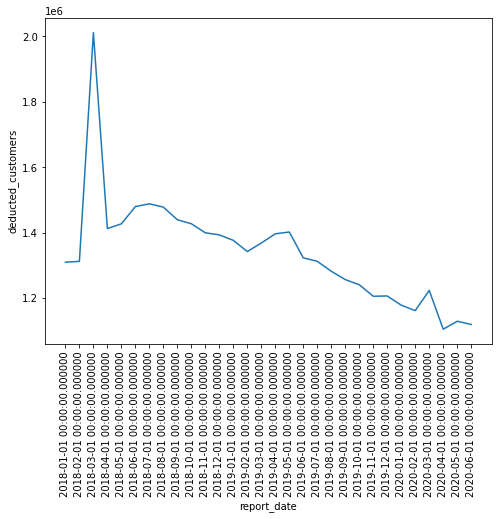

In [236]:
# graph total_deducted_customers_end_month by report_date

q = """
SELECT 
report_date,
SUM(total_deducted_customers_end_month) as deducted_customers
FROM data2
GROUP BY 1
"""

test = pysqldf(q)

plt.figure(figsize=(8,6))
ax = sns.lineplot(x="report_date", y="deducted_customers", data=test)
plt.xticks(rotation=90)
plt.show()

# q = """
# SELECT 
# report_date,
# individual_policy_price as policy_price,
# SUM(total_deducted_customers_end_month) as deducted_customers
# FROM data2
# GROUP BY 1,2
# """

# test2 = pysqldf(q)
# print(test2)

# plt.figure(figsize=(8,6))
# ax = sns.lineplot(x="report_date", y="deducted_customers", hue="policy_price", data=test2)
# plt.xticks(rotation=90)
# plt.show()

In [237]:
data2.head()

,confirmed_month,report_date,individual_policy_price,total_customers_end_month,payments,total_deducted_customers_end_month
0,2013-01-01 00:00:00.000000,2018-01-01 00:00:00.000000,30,199,2703.0,94
1,2013-01-01 00:00:00.000000,2018-02-01 00:00:00.000000,30,198,2480.0,91
2,2013-01-01 00:00:00.000000,2018-03-01 00:00:00.000000,30,197,2789.0,150
3,2013-01-01 00:00:00.000000,2018-04-01 00:00:00.000000,30,195,2486.0,91
4,2013-01-01 00:00:00.000000,2018-05-01 00:00:00.000000,30,201,2518.0,89


start_date: 2013-01-01 00:00:00.000000

unique prices: {40, 30}


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


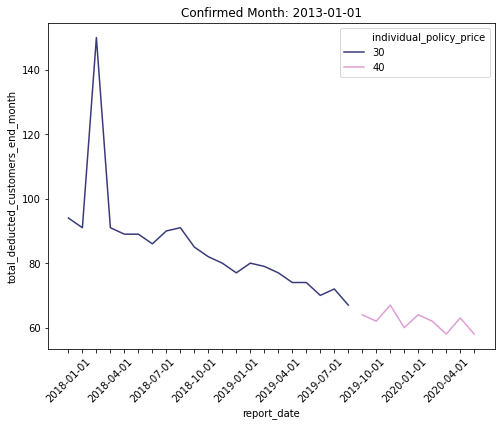

start_date: 2014-01-01 00:00:00.000000

unique prices: {40, 99, 30}


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


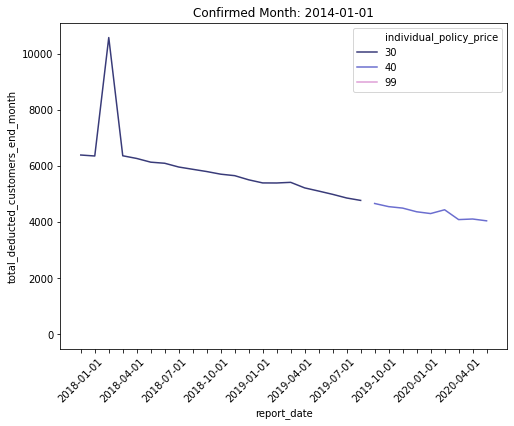

start_date: 2015-01-01 00:00:00.000000

unique prices: {40, 129, 99, 30}


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


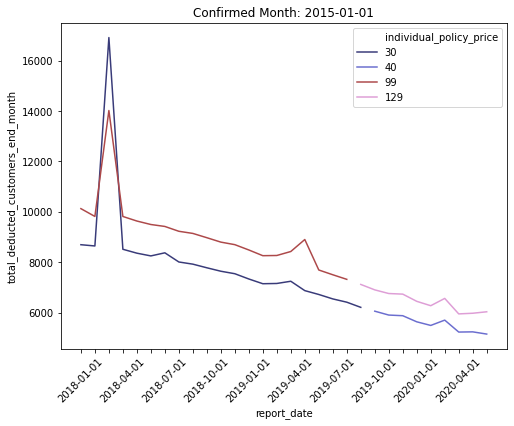

start_date: 2016-01-01 00:00:00.000000

unique prices: {40, 129, 99, 30}


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


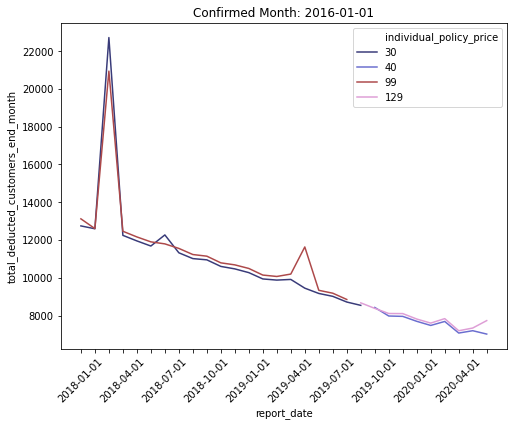

start_date: 2017-01-01 00:00:00.000000

unique prices: {129, 99, 40, 80, 60, 30}


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


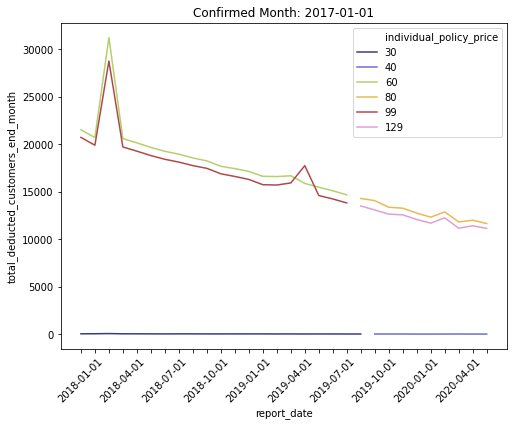

start_date: 2018-01-01 00:00:00.000000

unique prices: {129, 99, 100, 195, 40, 360, 75, 300, 80, 150, 60, 30}


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


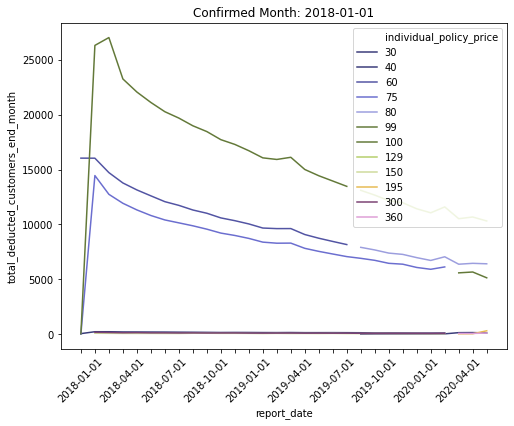

start_date: 2019-01-01 00:00:00.000000

unique prices: {129, 99, 100, 195, 40, 360, 75, 300, 80, 150, 60, 30}


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


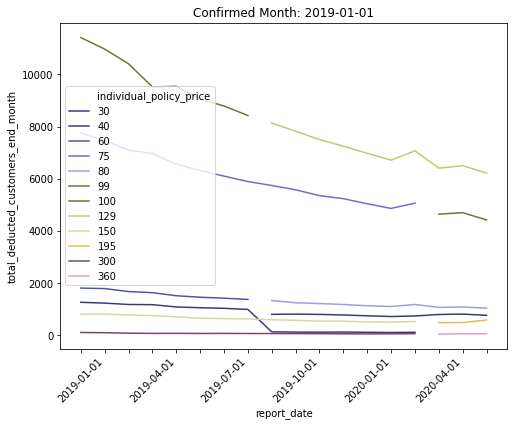

start_date: 2020-01-01 00:00:00.000000

unique prices: {129, 195, 100, 40, 360, 75, 300, 80, 150, 30}


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


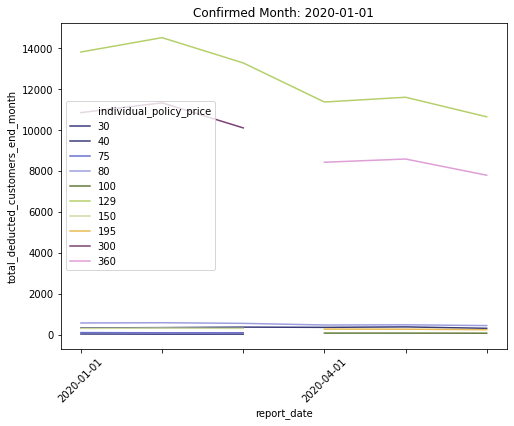

In [238]:
# graph total_deducted_customers_end_month by report_date for each confirmed month

# too many dates to draw them all out

dates = ['2013-01-01 00:00:00.000000',
         '2014-01-01 00:00:00.000000',
         '2015-01-01 00:00:00.000000',
         '2016-01-01 00:00:00.000000',
         '2017-01-01 00:00:00.000000',
         '2018-01-01 00:00:00.000000',
         '2019-01-01 00:00:00.000000',
         '2020-01-01 00:00:00.000000',]

def plot(date):
    test = data2[data2.confirmed_month == date]
    test['report_date'] = [str(x)[:10] for x in test.report_date]
    f = plt.figure(figsize=(8,6))
    ax = sns.lineplot(x="report_date", 
                      y="total_deducted_customers_end_month", 
                      hue="individual_policy_price", 
                      palette = "tab20b",
                      legend='full',
                      data=test)

    every_nth = 3
    for n, label in enumerate(ax.xaxis.get_ticklabels()):
        if n % every_nth != 0:
            label.set_visible(False)

    plt.xticks(rotation=45)
    plt.title('Confirmed Month: {}'.format(date[:10]))
    plt.show()
    return

def unique_prices(month):
    x = data2[data2.confirmed_month == month]
    print('unique prices:',set(x.individual_policy_price))
    return 


for i in dates:
    print('start_date:',i)
    print('')
    unique_prices(i)
    plot(i) 

In [ ]:
# graph total_deducted_customers_end_month by report_date for each confirmed month & price

In [ ]:
# check out the dip in june 2020, graph it somehow, might need to start with May 

In [241]:
# Creating a lookup for each month-price combination
# for each month, for each product, figure out a dynamic number of months to predict. 
# a lot of them seem to break down on the same date

q = """
SELECT 
confirmed_month,
individual_policy_price,
MAX(report_date) as max_report_date,
MIN(report_date) as min_report_date
FROM data2
GROUP BY 1,2
"""

test = pysqldf(q)
# print(test.max_report_date.value_counts())

test = pd.DataFrame(test)

test['confirmed_month'] = test.confirmed_month.apply(lambda x:datetime.strptime(x[:10],'%Y-%m-%d'))
test['max_report_date'] = test.max_report_date.apply(lambda x:datetime.strptime(x[:10],'%Y-%m-%d'))
test['min_report_date'] = test.min_report_date.apply(lambda x:datetime.strptime(x[:10],'%Y-%m-%d'))

end_datetime = datetime.strptime('2021/01/01','%Y/%m/%d')

test['months_to_predict'] = [relativedelta(end_datetime,x) for x in test.max_report_date]
test['months_to_predict'] = [(x.months + x.years*12) for x in test.months_to_predict]

test['months_available'] = [relativedelta(x,y) for x,y in zip(test.max_report_date,
                                                                            test.min_report_date)]
test['months_available'] = [(x.months + x.years*12) for x in test.months_available]

# months available has to be at least twice the prediction size for a model to work
test['ratio'] = [y/x for x,y in zip(test.months_to_predict, test.months_available)]

In [242]:
len(test)

621

In [243]:
len(test[test.ratio>2])

36

In [244]:
# joining above lookup back to the main data

q = """
SELECT 
a.*,
b.months_to_predict,
b.months_available,
b.ratio
FROM data2 a
LEFT JOIN test b 
ON a.confirmed_month=b.confirmed_month
AND a.individual_policy_price=b.individual_policy_price
"""

data3 = pysqldf(q)

In [195]:
# filtering out where ratio is less than 2

print('total start month - price combinations:',len(test))
print('')
print('viable start month - price combinations:',len(test[test.ratio>2]))

lookup = test[test.ratio>2]
lookup.confirmed_month = [str(x)[:10] for x in lookup.confirmed_month]

data4 = data3[data3.ratio>2]
data4.confirmed_month = [str(x)[:10] for x in data4.confirmed_month]

data4

total start month - price combinations: 621

viable start month - price combinations: 36


,confirmed_month,report_date,individual_policy_price,total_customers_end_month,payments,total_deducted_customers_end_month,months_to_predict,months_available,ratio
3686,2017-10-01,2018-01-01 00:00:00.000000,30,1192,28734.21,1054,10,26,2.6
3688,2017-10-01,2018-01-01 00:00:00.000000,75,1981,120252.52,1765,10,26,2.6
3690,2017-10-01,2018-01-01 00:00:00.000000,150,2784,319841.49,2425,10,26,2.6
3691,2017-10-01,2018-01-01 00:00:00.000000,300,3009,631454.90,2566,10,26,2.6
3692,2017-10-01,2018-02-01 00:00:00.000000,30,1181,24806.00,988,10,26,2.6
...,...,...,...,...,...,...,...,...,...
5239,2018-06-01,2020-02-01 00:00:00.000000,300,100,10560.02,57,10,21,2.1
5240,2018-06-01,2020-03-01 00:00:00.000000,30,165,2034.00,85,10,21,2.1
5242,2018-06-01,2020-03-01 00:00:00.000000,75,10567,281945.47,5363,10,21,2.1
5245,2018-06-01,2020-03-01 00:00:00.000000,150,269,12300.00,130,10,21,2.1


In [ ]:
#combinations of month & policy price for an iterative approach
# combos = list(zip(lookup.confirmed_month, lookup.individual_policy_price))
# data4[(data4.confirmed_month == combos[0][0]) & (data4.individual_policy_price == combos[0][1])]
# model_data = data4[(data4.confirmed_month == combos[0][0]) & (data4.individual_policy_price == combos[0][1])]

## Moving Window Model

In [323]:
def forecast(report_month, policy_price):
    
    # selecting data by month & policy
    model_data = data4[(data4.confirmed_month == report_month) 
                      & (data4.individual_policy_price == policy_price)]
    
    # Minimum reporting date - reformatting
    min_report_date = min(model_data.report_date)
    min_report_date = datetime.strptime(min_report_date[:10],'%Y-%m-%d')
    
    # Getting static values 
    months_to_predict = max(model_data.months_to_predict)
    confirmed_month = str(max(model_data.confirmed_month))[:10]
    policy_price = max(model_data.individual_policy_price)
    months_available = max(model_data.months_available)
    
    # Using 2/3 of the series to train model and last third for validation
    train_size = int(0.66 * months_available)

    # The time series
    values = list(model_data['total_deducted_customers_end_month'])    
    
    # Turning the series into a sliding window dataset
    t_minus2 = []
    t_minus1 = []
    t_zero = []
    t_one = []

    for i in range(len(values) - 3):
        t_minus2.append(values[i])
        t_minus1.append(values[i + 1])
        t_zero.append(values[i + 2])
        t_one.append(values[i + 3])
        
    # Predictors
    X = pd.DataFrame({
        't_minus2' : t_minus2,
        't_minus1' : t_minus1,
        't_zero' : t_zero})

    # Target variable
    y = t_one

    # Training Split
    X_train = X[:train_size]
    y_train = y[:train_size]
    
    # Model
#     model = LinearRegression(fit_intercept=True)
#     model = RandomForestRegressor(max_depth=50, random_state=0, n_estimators=100)
#     model = Lasso(alpha=0.05)
    model = BayesianRidge(n_iter = 200, normalize = False)
#     model = PassiveAggressiveRegressor(C = 0.95)
    model.fit(X_train, y_train)       

    
    # Predictions
    predictions = model.predict(X)
    predictions = [int(x) for x in predictions]
    
    # Model Coefficients - only for linear regression model
    print('Coefficients: \n', model.coef_)
    
    # R2 Scores
    print('train score:',round(model.score(X_train,y_train),3))
    print('test score:',round(model.score(X[train_size:],y[train_size:]),3))
    
    # Converting the Report dates to a better format
    plot_dates = list(model_data.report_date)[3:]
    plot_dates = [x[:10] for x in plot_dates]

    # Plotting the model performance vs Actual Values
    a = pd.DataFrame({'report_date': plot_dates,
                  'total_deducted_customers_end_month': predictions,
                  'source': 'model'
                 })


    b = pd.DataFrame({'report_date': plot_dates,
                  'total_deducted_customers_end_month': y,
                  'source' : 'actual'
                 })

    c = pd.concat([a,b])

    ax = sns.lineplot(x="report_date", 
                      y="total_deducted_customers_end_month", 
                      hue="source", 
                      palette = "CMRmap_r",
                      legend='full',
                      data=c)

    every_nth = 2
    for n, label in enumerate(ax.xaxis.get_ticklabels()):
        if n % every_nth != 0:
            label.set_visible(False)

    plt.xticks(rotation=45)
    plt.title('Confirmed Month: {} Policy Price: {}'.format(confirmed_month,
                                                            policy_price))

    plt.show()
    
    # Creating a dataset of the X values & predictions
    X3 = pd.DataFrame({
        't_minus2' : t_minus2,
        't_minus1' : t_minus1,
        't_zero' : t_zero,
        't_one' : t_one})

    # Looping through the end of the dataset to append next predictions
    for i in range(months_to_predict + 3):
        end = X3.tail(1)
        inputs = X3.tail(1)[['t_minus1','t_zero','t_one']]
        X3 = X3.append({'t_minus2' : int(end.t_minus1), 
                       't_minus1' : int(end.t_zero),
                       't_zero' : int(end.t_one),
                       't_one' : int(model.predict(inputs))}, 
                       ignore_index=True)
        
    # Adding new date labels and formatting for the forecast plot
    X3['report_month'] = [min_report_date + relativedelta(months=i) for i in range(len(X3))]
    X3['report_month'] = [str(x)[:10] for x in X3.report_month]
    X3['source'] = 'actual'
    X3['source'][-months_to_predict:] = 'predicted'

    # Plotting forecast
    ax = sns.lineplot(x="report_month", y="t_zero", 
                      hue="source", palette = "CMRmap_r", legend='full',data=X3)

    every_nth = 3
    for n, label in enumerate(ax.xaxis.get_ticklabels()):
        if n % every_nth != 0:
            label.set_visible(False)

    plt.xticks(rotation=45)
    plt.title('Confirmed Month: {}    Policy Price: {}'.format(confirmed_month, policy_price))
    plt.show()
    return


Coefficients: 
 [0.22771168 0.30289322 0.37760989]
train score: 0.994
test score: 0.799


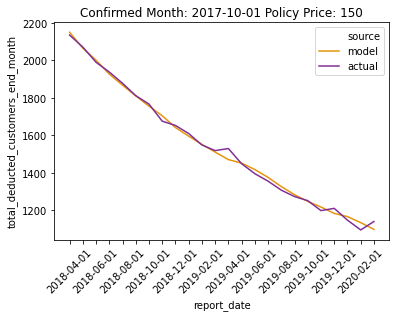

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


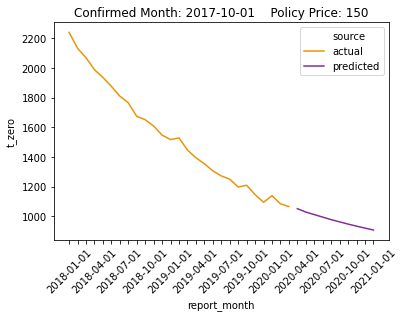

In [324]:
forecast('2017-10-01', 150)